# Import and Augment David's Data
The fly trajectory data from David's experiments lacks the necessary fields used in our estimator. In addition, the coordinate frame is the mirror-image of the coordinate frame we trained our estimator on, so this must also be taken into account. These problems, as well as more benign quality-of-life-changes, are made below. Note: this section needs only to be run once.

## Define Augmentation Function

In [1]:
import pynumdiff as pynd
import numpy as np
import pandas as pd

# augmentation function; copied from above for modularity in running sections
def augment_fly_trajectory(fly_trajectory_and_body: pd.DataFrame) -> pd.DataFrame:
    # extract groundspeed and groundspeed angle
    augmented_trajectory = fly_trajectory_and_body.copy()
    gnd_velocity_x, gnd_velocity_y = augmented_trajectory["velocity_x"],augmented_trajectory["velocity_y"]
    augmented_trajectory["groundspeed"] = np.sqrt(gnd_velocity_x**2 + gnd_velocity_y**2)
    augmented_trajectory["groundspeed_angle"] = np.arctan2(gnd_velocity_y,gnd_velocity_x)

    # extract airspeed and airspeed angle
    airspeed_x, airspeed_y = augmented_trajectory["airvelocity_x"],augmented_trajectory["airvelocity_y"]
    augmented_trajectory["airspeed"] = np.sqrt(airspeed_x**2 + airspeed_y**2)
    augmented_trajectory["airspeed_angle"] = np.arctan2(airspeed_y,airspeed_x)
    
    # compute linear acceleration and linear acceleration angle
    params = [2, 10, 10]
    dt = np.median(np.diff(augmented_trajectory.timestamp))
    _, accel_x = pynd.linear_model.savgoldiff(augmented_trajectory["velocity_x"], dt,params)
    _, accel_y = pynd.linear_model.savgoldiff(augmented_trajectory["velocity_y"], dt,params)
    augmented_trajectory["linear_acceleration"] = np.sqrt(accel_x ** 2 + accel_y ** 2)
    augmented_trajectory["linear_acceleration_angle"] = np.arctan2(accel_y, accel_x) 

    # compute thrust and thrust angle
    mass=0.25e-6
    dragcoeff = mass / 0.170
    thrust_x = mass * accel_x + dragcoeff * airspeed_x
    thrust_y = mass * accel_y + dragcoeff * airspeed_y
    augmented_trajectory["thrust"] = np.sqrt(thrust_x ** 2 + thrust_y ** 2)
    augmented_trajectory["thrust_angle"] = np.arctan2(thrust_y, thrust_x)
    return augmented_trajectory

2024-12-20 13:35:47,931 [INFO] NumExpr defaulting to 12 threads.


## Import David's Data and Make Minor Changes 
As the name suggests, this section is focused on importing David's data and making a few minor but important modifications (like changing field names, extracting only relevant data, etc...)

In [2]:
path_to_David_data_raw = f'../ExperimentalData/laminar_orco_flash.csv'

In [3]:
# import data and rename fields
temp_fly_data = pd.read_csv(path_to_David_data_raw)
temp_fly_data.rename(columns={'obj_id':'trajec_objid','x': 'position_x','y': 'position_y','heading':'heading_angle',"xvel": "velocity_x","yvel": "velocity_y"},inplace=True)

# include only relevant fields
temp_fly_data = temp_fly_data[["trajec_objid", "timestamp", "position_x", "position_y", "velocity_x", "velocity_y","heading_angle"]]

# add necessary fields
temp_fly_data['windspeed'] = 0.4
temp_fly_data['windspeed_angle'] = -np.pi
temp_fly_data['airvelocity_x'] = temp_fly_data['velocity_x'] + 0.4
temp_fly_data['airvelocity_y'] = temp_fly_data['velocity_y'] 
temp_fly_data['heading_angle_x'] = np.cos(temp_fly_data['heading_angle']) 
temp_fly_data['heading_angle_y'] = np.sin(temp_fly_data['heading_angle']) 

# start each merged dataframe at 0, for consistency
def transform_timestamps_to_start_at_zero(fly_trajectory_and_body: pd.DataFrame) -> pd.DataFrame:
    fly_trajectory_and_body["timestamp"] = fly_trajectory_and_body["timestamp"] - fly_trajectory_and_body["timestamp"][0]
    fly_trajectory_and_body["timestamp"] = fly_trajectory_and_body["timestamp"].round(2)
    return fly_trajectory_and_body

# Split the DataFrame into a list of DataFrames based on the 'key' column
temp_fly_data = [group for _, group in temp_fly_data.groupby('trajec_objid')]

# filter trajectories based on length
temp_fly_data = [trajectory for trajectory in temp_fly_data if len(trajectory) > 12]

## Call Augmentation Function and Write New Dataset
After making the above changes, we augment each trajectory in David's data and then concatentte the trajectories into one large dataframe, which we then write to ExperimentalData folder for later use. 

In [4]:
path_to_David_data_aug = f'../ExperimentalData/david_data_augmented.csv'

In [5]:
temp_fly_data = [augment_fly_trajectory(trajectory) for trajectory in temp_fly_data]
David_fly_data = pd.concat(temp_fly_data, ignore_index=True)
David_fly_data.to_csv((path_to_David_data_aug))

# Predict Headings for Augmented David's Data

## Import Augmented David's Data
Import the augmented data into a dataframe and create a list of trajectories

In [6]:
path_to_David_data_aug = f'../ExperimentalData/david_data_augmented.csv'

In [7]:
David_fly_data = pd.read_csv(path_to_David_data_aug)
body_and_trajectory_by_id = [group for _, group in David_fly_data.groupby('trajec_objid')]

## Define Time-Delay Embedding Function
In addition to augmenting David's data with new fields, the data also needs to be augmented with a time-delay embedding. This is done below. Note: None of the parameters below can be changed, as the estimator was trained on training data that used these inputs. 

In [8]:
input_names = [
    'groundspeed',
    'groundspeed_angle',
    'windspeed',
     'windspeed_angle',
    'airspeed',
    'airspeed_angle',
    'thrust',
    'thrust_angle',
]

output_names = ['heading_angle_x', 'heading_angle_y']

time_window = 4

time_augmentation_kwargs = {
    "time_window": time_window,
    "input_names": input_names,
    "output_names": output_names,
    "direction": "backward"
}

In [9]:
def augment_with_time_delay_embedding(fly_traj_list: list[pd.DataFrame],**kwargs):
    def collect_offset_rows(df, aug_column_names=None, keep_column_names=None, w=1, direction='backward'):
        """ Takes a pandas data frame with n rows, list of columns names, and a window size w.
            Then creates an augmented data frame that collects prior or future rows (in window)
            and stacks them as new columns. The augmented data frame will be size (n - w - 1) as the first/last
            w rows do not have enough data before/after them.

            Inputs
                df: pandas data frame
                aug_column_names: names of the columns to augment
                keep_column_names: names of the columns to keep, but not augment
                w: lookback window size (# of rows)
                direction: get the rows from behind ('backward') or front ('forward')

            Outputs
                df_aug: augmented pandas data frame.
                        new columns are named: old_name_0, old_name_1, ... , old_name_w-1
        """

        df = df.reset_index(drop=True)

        # Default for testing
        if df is None:
            df = np.atleast_2d(np.arange(0, 11, 1, dtype=np.double)).T
            df = np.matlib.repmat(df, 1, 4)
            df = pd.DataFrame(df, columns=['a', 'b', 'c', 'd'])
            aug_column_names = ['a', 'b']
        else:  # use the input  values
            # Default is all columns
            if aug_column_names is None:
                aug_column_names = df.columns

        # Make new column names & dictionary to store data
        new_column_names = {}
        df_aug_dict = {}
        for a in aug_column_names:
            new_column_names[a] = []
            df_aug_dict[a] = []

        for a in aug_column_names:  # each augmented column
            for k in range(w):  # each point in lookback window
                new_column_names[a].append(a + '_' + str(k))

        # Augment data
        n_row = df.shape[0]  # # of rows
        n_row_train = n_row - w + 1  # # of rows in augmented data
        for a in aug_column_names:  # each column to augment
            data = df.loc[:, [a]]  # data to augment
            data = np.asmatrix(data)  # as numpy matrix
            df_aug_dict[a] = np.nan * np.ones((n_row_train, len(new_column_names[a])))  # new augmented data matrix

            # Put augmented data in new column, for each column to augment
            for i in range(len(new_column_names[a])):  # each column to augment
                if direction == 'backward':
                    # Start index, starts at the lookback window size & slides up by 1 for each point in window
                    startI = w - 1 - i

                    # End index, starts at end of the matrix &  & slides up by 1 for each point in window
                    endI = n_row - i  # end index, starts at end of matrix &

                elif direction == 'forward':
                    # Start index, starts at the beginning of matrix & slides up down by 1 for each point in window
                    startI = i

                    # End index, starts at end of the matrix minus the window size
                    # & slides down by 1 for each point in window
                    endI = n_row - w + 1 + i  # end index, starts at end of matrix &

                else:
                    raise Exception("direction must be 'forward' or 'backward'")

                # Put augmented data in new column
                df_aug_dict[a][:, i] = np.squeeze(data[startI:endI, :])

            # Convert data to pandas data frame & set new column names
            df_aug_dict[a] = pd.DataFrame(df_aug_dict[a], columns=new_column_names[a])

        # Combine augmented column data
        df_aug = pd.concat(list(df_aug_dict.values()), axis=1)

        # Add non-augmented data, if specified
        if keep_column_names is not None:
            for c in keep_column_names:
                if direction == 'backward':
                    startI = w - 1
                    endI = n_row
                elif direction == 'forward':
                    startI = 0
                    endI = n_row - w
                else:
                    raise Exception("direction must be 'forward' or 'backward'")

                keep = df.loc[startI:endI, [c]].reset_index(drop=True)
                df_aug = pd.concat([df_aug, keep], axis=1)

        return df_aug
    time_window = kwargs["time_window"]
    input_names = kwargs["input_names"]
    output_names = kwargs["output_names"]
    direction = kwargs["direction"]
    traj_augment_list = []
    for traj in fly_traj_list:
        traj_augment = collect_offset_rows(traj,
                                                aug_column_names=input_names,
                                                keep_column_names=output_names,
                                                w=time_window,
                                                direction=direction)

        traj_augment_list.append(traj_augment)

    traj_augment_all = pd.concat(traj_augment_list, ignore_index=True)

    return np.round(traj_augment_all, 4)

## Define Prediction Function

The prediction function plots the predicted headings along with the given headings (which, in the case of David's data, is just the course direction). 

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import fly_plot_lib_plot as fpl
import matplotlib.colors as mcolors
from keras.models import load_model
from scipy.ndimage import gaussian_filter1d
import pandas as pd

# Load the pre-trained model
best_estimator = load_model('model.keras')

# Define colormaps for trajectory visualization
blue_cmap = mcolors.LinearSegmentedColormap.from_list('blue_cmap', ['blue', 'blue'])
red_cmap = mcolors.LinearSegmentedColormap.from_list('red_cmap', ['red', 'red'])

def plot_trajectory_with_predicted_heading(
        trajectory: pd.DataFrame,
        axis: plt.Axes,
        best_estimator: callable,
        n_input: int = 32,
        nskip: int = 0,
        arrow_size=None,
        include_id=False,
        smooth=False,
        **kwargs):
    """
    Plot a trajectory with its predicted heading using a trained model.

    Parameters:
    - trajectory (pd.DataFrame): DataFrame containing fly trajectory data with 'position_x', 'position_y', and 'heading_angle'.
    - axis (plt.Axes): Matplotlib axis object to draw the plots.
    - best_estimator (callable): Trained model for heading prediction.
    - n_input (int): Number of input features for prediction. Default is 32.
    - nskip (int): Number of trajectory points to skip for visual clarity. Default is 0.
    - arrow_size: Size of the arrows in the plot.
    - include_id (bool): Whether to include trajectory ID as the axis title. Default is False.
    - smooth (bool): Whether to apply Gaussian smoothing to predicted headings. Default is False.
    - **kwargs: Additional arguments passed to the time-delay embedding augmentation function.

    Returns:
    - np.ndarray: Array of predicted heading angles.
    """

    def predict_heading_from_fly_trajectory(df: pd.DataFrame, n_input, augment_with_time_delay_embedding: callable, estimator: callable, smooth=False, **kwargs):
        """
        Predict heading angles from a trajectory using a trained model.

        Parameters:
        - df (pd.DataFrame): DataFrame containing trajectory data.
        - n_input (int): Number of input features for prediction.
        - augment_with_time_delay_embedding (callable): Function to augment data with time-delay embedding.
        - estimator (callable): Trained model for prediction.
        - smooth (bool): Whether to apply Gaussian smoothing to predicted headings. Default is False.

        Returns:
        - np.ndarray: Array of predicted heading angles.
        """
        augmented_df = augment_with_time_delay_embedding([df], **kwargs)
        augmented_df = augmented_df.iloc[:, 0:n_input]
        heading_components = estimator.predict(augmented_df)

        if smooth:
            # Apply Gaussian smoothing
            sigma = 2  # Standard deviation for the Gaussian filter
            heading_components = gaussian_filter1d(heading_components, sigma=sigma, axis=0)

        heading_angle_predicted = np.arctan2(heading_components[:, 1], heading_components[:, 0])

        # Handle time steps removed by augmentation
        num_deleted_steps = len(df["position_x"]) - len(heading_angle_predicted)
        prepend_values = np.full(num_deleted_steps, heading_angle_predicted[0])
        heading_angle_predicted_arr = np.concatenate([prepend_values, heading_angle_predicted])

        return heading_angle_predicted_arr

    def plot_trajectory(xpos, ypos, phi, color, ax=None, size_radius=None, nskip=0,
                        colormap='bone_r', colornorm=None, edgecolor='none', reverse=False, alpha=0.7):
        """
        Plot a trajectory with optional color mapping and size adjustments.

        Parameters:
        - xpos, ypos (np.ndarray): X and Y coordinates of the trajectory.
        - phi (np.ndarray): Orientation angles for each point in the trajectory.
        - color (np.ndarray): Array used for color mapping.
        - ax (plt.Axes): Matplotlib axis object for plotting.
        - size_radius: Radius size of trajectory markers.
        - nskip (int): Number of points to skip for visual clarity.
        - colormap (str): Name of the colormap to use.
        - colornorm (list): Color normalization limits.
        - edgecolor (str): Color of marker edges.
        - reverse (bool): Whether to reverse the trajectory.
        - alpha (float): Transparency level of the markers.
        """
        if color is None:
            color = phi

        color = np.array(color)

        # Set size radius
        if size_radius is None:
            xymean = np.mean(np.abs(np.hstack((xpos, ypos))))
            size_radius = max(0.21 * xymean, 0.01)

        if colornorm is None:
            colornorm = [np.min(color), np.max(color)]

        if reverse:
            xpos, ypos, phi, color = map(np.flip, (xpos, ypos, phi, color))

        fpl.colorline_with_heading(
            ax, xpos, ypos, color, phi, nskip=nskip, size_radius=size_radius, deg=False,
            colormap=colormap, center_point_size=0.0001, colornorm=colornorm, show_centers=False,
            size_angle=20, alpha=alpha, edgecolor=edgecolor
        )

        ax.set_aspect('equal')

        # Define fixed minimum plot size
        min_size = 0.1
        xrange = max(xpos.max() - xpos.min(), min_size)
        yrange = max(ypos.max() - ypos.min(), min_size)
        ax.set_xlim(xpos.min() - 0.2 * xrange, xpos.max() + 0.2 * xrange)
        ax.set_ylim(ypos.min() - 0.2 * yrange, ypos.max() + 0.2 * yrange)

        if include_id:
            ax.set_title(trajectory['trajec_objid'].iloc[0])

    # Predict heading angles
    heading_angle_predicted = predict_heading_from_fly_trajectory(
        trajectory, n_input, augment_with_time_delay_embedding, best_estimator, smooth=smooth,**kwargs
    )

    # Plot the predicted heading trajectory
    plot_trajectory(
        trajectory.position_x.values,
        trajectory.position_y.values,
        heading_angle_predicted,
        trajectory.timestamp.values,
        ax=axis,
        size_radius=arrow_size,
        nskip=nskip,
        colormap=blue_cmap,
        edgecolor='none',
        reverse=False,
        alpha=0.7
    )

    # Plot the actual trajectory
    plot_trajectory(
        trajectory.position_x.values,
        trajectory.position_y.values,
        trajectory.heading_angle.values,
        trajectory.timestamp.values,
        ax=axis,
        size_radius=arrow_size,
        nskip=nskip,
        colormap=red_cmap,
        edgecolor="black",
        reverse=False,
        alpha=0.3
    )

    return heading_angle_predicted


2024-12-20 13:36:09.394293: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-20 13:36:09.425011: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-20 13:36:09.467263: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-20 13:36:09.475836: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-20 13:36:09.478718: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-20 13:36:09.489705: I tensorflow/core/platform/cpu_feature_gu

## Visualize Trajectory by ID

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step


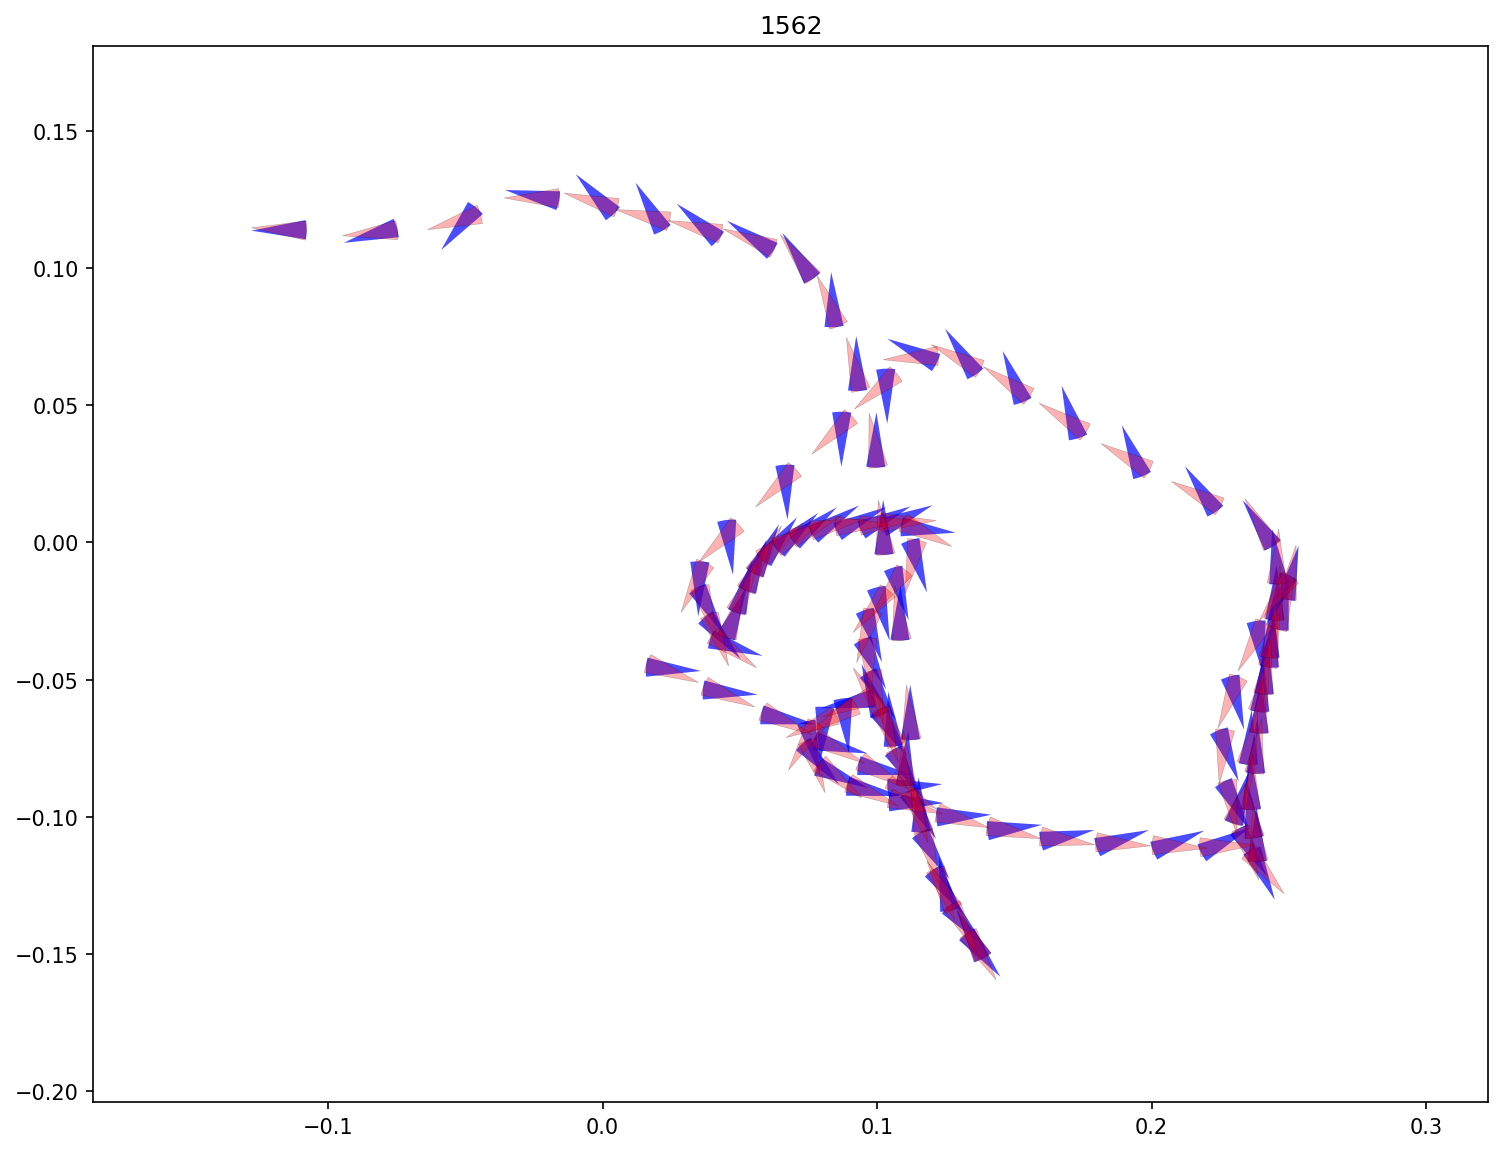

In [18]:
test_trajec_David = David_fly_data.loc[David_fly_data["trajec_objid"]==1562]
fig, ax = plt.subplots(figsize=(12, 12), dpi=150)
predicted_heading = plot_trajectory_with_predicted_heading(test_trajec_David,ax,best_estimator,include_id=True,nskip=4,smooth=True,**time_augmentation_kwargs)

## Visualize ALL Trajectories
Useful for finding trajectories that are particularly interesting. Make sure the svg folder is created and pathed correctly before running this; otherwise, it will not run or will save the svgs in an undesirable location.

In [ ]:
import gc
# Loop through each trajectory and create/save figures
for trajectory in body_and_trajectory_by_id:
    trajec_objid = trajectory["trajec_objid"].iloc[0]
    fig, ax = plt.subplots(figsize=(12, 12), dpi=150)
    predicted_heading = plot_trajectory_with_predicted_heading(trajectory,ax,best_estimator,include_id=True,nskip=4,smooth=True,**time_augmentation_kwargs)
    
    # Save the figure as an SVG file
    svg_filename = f'../FigurePlots/neurel_net_david_data_svg/{trajec_objid}.svg'
    plt.savefig(svg_filename, format='svg')
    plt.close(fig)  # Close the figure to free up memory
    gc.collect()